In [1]:
import numpy as np
import statistics as ST
import pandas as pd
import scipy.stats
import random
import copy
import time
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import colors
from matplotlib import gridspec
import json
from matplotlib import cm
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42

##  **1 Preparation**

###  **1.1 Input**

In [2]:
# This is the absolute path
Path_ab2="C:/Users/lumia/Dropbox (University of Michigan)/1. Haiqing Xu/1. Project/10. Genetic code against nutrient limitation/"
# This is the aminoacid properties
aa2=Path_ab2+'/Amino_acid_properites/Nutrient_metrics.csv'
Path_ab3="F:/Science_critical_comment_data/"

In [3]:
# nutrient data
Nutrient_data=pd.read_csv(aa2)
Nutrient_data.set_index('Amino acid',inplace=True)
# codon frequency data
codon_freq_address=Path_ab2+'/Codon_frequency_table/ModelOrganisms.csv'

In [4]:
# read the codon frequency information into a pandas dataframe
codon_freq=pd.read_csv(codon_freq_address)
# Drop unnecessary columns
codon_freq=codon_freq.drop(columns=['Unnamed: 0','Assembly','Translation Table','Organelle','Division'])

In [5]:
# this list contains the codon names
codon_freq_name_list=codon_freq.columns[8:]

In [6]:
# this is the address for pvalue
# pvalue data for Figure 2
pvalue_dic_address_1=Path_ab3+'1e6_Figure4_NC_no_stop/pvalue_dictionary.json'
# pvalue data for Figure S2
pvalue_dic_address_2=Path_ab3+'1e6_Figure4_My_simulation_NC/pvalue_dictionary.json'
# pvalue data for Figure S3
pvalue_dic_address_3=Path_ab3+'1e6_Figure4_NC/pvalue_dictionary.json'

###  **1.2 Functions**

In [7]:
def read_benchmark(input_address):
    temp_list=[]
    with open(input_address,'r') as handler:
        handler.readline()
        temp=handler.readline().strip().split(',')
        temp_list=[float(x) for x in temp]
    return(temp_list)

In [8]:
def extract_one_measurement(Group_name,total_dic,number):
# The group_name is the name of group that I want to extract, number indicate which property I want to look at.
# To be noted,
    temp_dic=total_dic[Group_name]
    total_matrix=[]
    for key,value in temp_dic.items():
        temp_list=[]
        for sub_value in value:
            temp_list.append(sub_value[number])
        total_matrix.append(temp_list)
    return(np.array(total_matrix))

In [9]:
def unpacking(input_dict):
    temp_df=[]
    for value in input_dict.values():
        for sub_value in value.values():
            temp_df.append(np.mean(np.array(sub_value)[1:,], axis=0))
    return(temp_df)

In [10]:
def find_sig_species(input_dict,cutoff):
    # this function take the pvalue dictionary as input and generate a list of label for all the species
    # cutoff is the number of pvalue across all the Ts/Tv value to be used to determine if a species' UGC is significant or not
    temp_list=[]
    for value in input_dict.values():
        for sub_value in value.values():
            temp_label=[]
            for x in np.transpose(sub_value[1:]): # be careful to skip the first one, it is the LD hurst version
                temp_sum=sum(np.array(x)<0.05)
                if temp_sum>=cutoff:
                    temp_label.append("sig")
                else:
                    temp_label.append("none_sig")
            temp_list.append(temp_label)
    return(temp_list)

In [11]:
def unpacking_V2(input_dict,order):
    # order describe which Ts/Tv ratio we choose
    temp_df=[]
    for value in input_dict.values():
        for sub_value in value.values():
            # be careful to skip the first one, it is the LD hurst version
            temp_df.append(sub_value[order+1])
    return(temp_df)

###  **1.3 UGC structure**

In [12]:
# make a dictionary, the codon is the key, while the aa is the value
UGC_table = { 
'TTT':'F', 'TTC':'F', 'TTA':'L', 'TTG':'L', 
'TCT':'S', 'TCC':'S', 'TCA':'S', 'TCG':'S', 
'TAT':'Y', 'TAC':'Y', 'TAA':'_', 'TAG':'_', 
'TGT':'C', 'TGC':'C', 'TGA':'_', 'TGG':'W', 
'CTT':'L', 'CTC':'L', 'CTA':'L', 'CTG':'L', 
'CCT':'P', 'CCC':'P', 'CCA':'P', 'CCG':'P', 
'CAT':'H', 'CAC':'H', 'CAA':'Q', 'CAG':'Q', 
'CGT':'R', 'CGC':'R', 'CGA':'R', 'CGG':'R',     
'ATT':'I', 'ATC':'I', 'ATA':'I', 'ATG':'M', 
'ACT':'T', 'ACC':'T', 'ACA':'T', 'ACG':'T', 
'AAT':'N', 'AAC':'N', 'AAA':'K', 'AAG':'K', 
'AGT':'S', 'AGC':'S', 'AGA':'R', 'AGG':'R',                  
'GTT':'V', 'GTC':'V', 'GTA':'V', 'GTG':'V',  
'GCT':'A', 'GCC':'A', 'GCA':'A', 'GCG':'A',
'GAT':'D', 'GAC':'D', 'GAA':'E', 'GAG':'E', 
'GGT':'G', 'GGC':'G', 'GGA':'G', 'GGG':'G', 
       
    } 

###  **1.3 Seperate species accoridng to kingdom**

In [15]:
Bacteria_group=[2097,1423,562,354,100226]
Extremophiles_group=[41673,272844,1917166,694429,3046,797304,243230]
Unicelluar_Eukaryotes_group=[4896,4932,35128,162425,2903,3055]
Plants_group=[3702,34305,3694,3218,4530,4577]
Animals_group=[6239,8364,7070,7955,9031,9598,10181,10090,10116,8296,9615,9606,7227,9685,59729]

In [16]:
Total_frequency_table=[Bacteria_group,Extremophiles_group,Unicelluar_Eukaryotes_group,Plants_group,Animals_group]
Group_name_list=['Bacteria','Extremophiles','Unicelluar_Eukaryotes','Plants','Animals']

##  **2 Calculation**

###  **2.1 pvalue of UGC**

In [17]:
# ratio list for Ts/Tv bias
ratio_list=[0.2,1/4,1/3,0.5,1,2,3,4,5]
# I create a list to store dictionarys for Ts/Tv metrics
TsTv_list=[]
TsTv_list.append({1:2,2:5,3:1})
Position_list=[]
Position_list.append({1:0.5,2:0.1,3:1})
for x in range(1,10):
    temp_dict={1:ratio_list[x-1],2:ratio_list[x-1],3:ratio_list[x-1]}
    TsTv_list.append(temp_dict)
    Position_list.append({1:1,2:1,3:1})

In [18]:
with open(pvalue_dic_address_1) as f:
    tt=json.load(f)
Total_pvalue_dic_NC_NS= json.loads(tt)

In [19]:
with open(pvalue_dic_address_2) as f:
    tt=json.load(f)
Total_pvalue_dic_MS_NC= json.loads(tt)

In [20]:
with open(pvalue_dic_address_3) as f:
    tt=json.load(f)
Total_pvalue_dic_NC= json.loads(tt)

In [21]:
# Here I convert the property dataframe into a dic, the key is the shortname for AA, and values are corresponding property value
property_dic={}
for index, row in Nutrient_data.iterrows():
    property_dic[index]=[x for x in row] # The aa short name is a key and the propery is the value
# adding the option of stop codon.
property_dic['_']=[0,0,0]

###  **2.2.3 Codon usage**

In [22]:
cd_property_dic=[]
for x in codon_freq_name_list:
    cd_property_dic.append(property_dic[UGC_table[x]])
cd_property_dic=np.transpose(cd_property_dic)

In [23]:
len(np.delete(cd_property_dic[0],[18,19,50]))

61

In [24]:
####  **1.2.1 Codon usage analysis**
# correlation based on codon sequence
Total_cd_freq_dic={}
UGC_ERMC_dic={}
for num,species_group in enumerate(Group_name_list):
    temp_suffix=species_group
    temp_group=Total_frequency_table[num]
    temp_cd_freq_dic={}
    General_path=Path_ab3+'1e6_Figure4_NC_no_stop/'+temp_suffix+'/'
    temp_ERMC_UGC_dic={}
    if not os.path.isdir(General_path):
        os.mkdir(General_path)
    for species_taxid in temp_group:
        species_name=codon_freq[codon_freq['Taxid']==species_taxid].iloc[0,]['Species']
        ERMC_UGC_summary=[]
        sub_general_path=General_path+species_name+'/'
        if not os.path.isdir(sub_general_path):
            os.mkdir(sub_general_path)
        freq_value=codon_freq[codon_freq['Taxid']==species_taxid].iloc[0, 8:]
        # These are the list containing all the coefficients
        pearson_coef=[]
        spearman_coef=[]
        # These are the list containing all the pvalue
        pearson_pvalue=[]
        spearman_pvalue=[]
        for row in cd_property_dic:
            t_p=scipy.stats.pearsonr(np.delete(freq_value.tolist(),[18,19,50]),np.delete(row,[18,19,50]))
            t_s=scipy.stats.spearmanr(np.delete(freq_value.tolist(),[18,19,50]),np.delete(row,[18,19,50]))
            pearson_coef.append(t_p[0])
            pearson_pvalue.append(t_p[1])
            spearman_coef.append(t_s[0])
            spearman_pvalue.append(t_s[1])
        temp_cd_freq_dic[species_name]=[pearson_coef,spearman_coef,pearson_pvalue,spearman_pvalue]
        for idx,item in enumerate(TsTv_list):
            sv_list=item
            po_list=Position_list[idx]
            name_suffix='_set'+str(idx)
            #  UGC
            UGC_tsub_ERMC_address=sub_general_path+'UGC_tsub_ERMC'+name_suffix
            UGC_tsub_ERMC=read_benchmark(UGC_tsub_ERMC_address)
            ERMC_UGC_summary.append(UGC_tsub_ERMC)
        temp_ERMC_UGC_dic[species_name]=ERMC_UGC_summary
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(current_time)
    Total_cd_freq_dic[species_group]=temp_cd_freq_dic
    UGC_ERMC_dic[species_group]=temp_ERMC_UGC_dic

13:34:31
13:34:32
13:34:32
13:34:32
13:34:32


In [25]:
total_pearson_coef_cd=[]
total_pearson_pvalue_cd=[]
total_spearman_coef_cd=[]
total_spearman_pvalue_cd=[]
total_codon=[]
for value in Total_cd_freq_dic.values():
    for sub_key,sub_value in value.items():
        total_codon.append(codon_freq[codon_freq['Species']==sub_key]['GC%'].item())
        total_pearson_coef_cd.append(sub_value[0])
        total_spearman_coef_cd.append(sub_value[1])
        total_pearson_pvalue_cd.append(sub_value[2])
        total_spearman_pvalue_cd.append(sub_value[3])

In [26]:
print(scipy.stats.pearsonr(x=np.transpose(total_pearson_coef_cd)[0],y=total_codon))

(-0.6607191364877647, 4.702464833137475e-06)


In [27]:
print(scipy.stats.pearsonr(x=np.transpose(total_pearson_coef_cd)[2],y=total_codon))

(0.5859569934632665, 8.8821277820438e-05)


In [41]:
input_freq_names = ['../Data/BS_freq.txt','../Data/EC_freq.txt','../Data/SCA_freq.txt','../Data/SP_freq.txt','../Data/SC_freq.txt','../Data/CR_freq.txt']

In [42]:
total_pearson_coef_cd_transcriptome=[] # correlation based on transcriptome
freq_matrix=[]
for name in input_freq_names:
    SC_freq_vec=[]
    with open(name,'r') as hand:
        temp=hand.readline().strip()
        while temp:
            SC_freq_vec.append(float(temp))
            temp=hand.readline().strip()
    coefficient_list=[]
    freq_matrix.append(SC_freq_vec)
    for row in cd_property_dic:
        temp=scipy.stats.pearsonr(np.delete(SC_freq_vec,[18,19,50]),np.delete(row,[18,19,50]))
        coefficient_list.append(temp[0])
    total_pearson_coef_cd_transcriptome.append(coefficient_list)

In [44]:
list_with_expression = [1,2,4,12,13,17] # these are the species with expression data

###  **2.2.3 Negative correlation between UGC's robustness and optimization level of codon usage

In [28]:
total_pvalue_NC_3=unpacking_V2(Total_pvalue_dic_NC,6)
total_pvalue_MS_NC_3=unpacking_V2(Total_pvalue_dic_MS_NC,6)
total_pvalue_NC_NS_3=unpacking_V2(Total_pvalue_dic_NC_NS,6)

###  **1.2 Figure**

####  **1.2.1 Figure 2**

In [29]:
sig_label=find_sig_species(Total_pvalue_dic_NC,1)

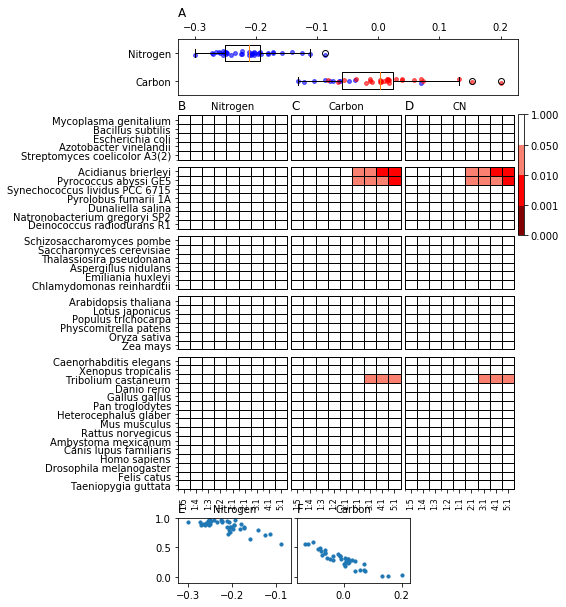

In [37]:
new_path=Path_ab2+'Figure'
pname=new_path+'/Figure1.pdf'
Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']

# y axis label
#  x_label=['$\dfrac{1}{5}$','$\dfrac{1}{4}$','$\dfrac{1}{3}$','$\dfrac{1}{2}$','$\dfrac{1}{1}$','$\dfrac{2}{1}$','$\dfrac{3}{1}$','$\dfrac{4}{1}$','$\dfrac{5}{1}$']
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
# the width ratio of subplot
# I exclude bacteria
height_ratios=[len(Total_pvalue_dic_NC[x].keys()) for x in Group_name_list]
height_ratios=[0.2*sum(height_ratios)]+height_ratios+[0.25*sum(height_ratios)]
fig1,axes = plt.subplots(7, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(8,10),sharey='row')



# The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

# This is for plotting the boxplot



gs = gridspec.GridSpec(58,61) 
ax1=fig1.add_subplot(gs[0:6,0:60])  

ax1.set_title('A',loc='left',fontsize=12)
r_coef_df = pd.DataFrame({'pearson_coef_cd':np.transpose(total_pearson_coef_cd)[2].tolist()+np.transpose(total_pearson_coef_cd)[0].tolist(),
    'nutrient':['Nitrogen']*len(total_pearson_coef_cd)+['Carbon']*len(total_pearson_coef_cd),'sig_label':np.transpose(sig_label)[2].tolist()+np.transpose(sig_label)[0].tolist()})
group = ['nutrient','sig_label']
column = 'pearson_coef_cd'
grouped = r_coef_df.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
new_vals=[vals[0]+vals[1],vals[2]]
new_names=['Carbon','Nitrogen']
ax1.boxplot(new_vals, labels=new_names,vert=0,widths = 0.6)
#  ngroup = len(vals)
clevels = ['blue','red','blue']
point_size=15
ax1.scatter(vals[0], xs[0],  alpha=0.6,s=point_size,c=clevels[0])
ax1.scatter(vals[1],  xs[1]-1, alpha=0.6,s=point_size,c=clevels[1])
ax1.scatter(vals[2], xs[2]-1,  alpha=0.6,s=point_size,c=clevels[2])

ax1.xaxis.tick_top()

# this is for heatmap
for a,b,c in zip(range(3),Nutrient_list,Nutrient_name_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,1:7],Group_name_list):

        temp_data=extract_one_measurement(y,Total_pvalue_dic_NC_NS,b)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1
        # set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic_NC_NS[y].keys())))

        # set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_NC_NS[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        # here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        x.set_xticklabels(x_label,fontsize=8,rotation='vertical')
        x.set_yticklabels(Total_pvalue_dic_NC_NS[y].keys())
        if count!=5:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[1,0].set_title('Nitrogen',loc='center',fontsize=10)
axes[1,0].set_title('B',loc='left',fontsize=12)

axes[1,1].set_title('Carbon',loc='center',fontsize=10)
axes[1,1].set_title('C',loc='left',fontsize=12)

axes[1,2].set_title('CN',loc='center',fontsize=10)
axes[1,2].set_title('D',loc='left',fontsize=12)

# I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')
    
for x in axes[0,]:
    x.axis('off')

for x in axes[6,]:
    x.axis('off')
ax2=fig1.add_subplot(gs[8:21,60:])  
plt.colorbar(im,cax=ax2)

#  ax1=fig1.add_subplot(gs[0:9,0:20])  

ax3=fig1.add_subplot(gs[51:,:20]) 
ax3.set_ylim(-0.1, 1)
ax3.set_title('E',loc='left',fontsize=12)
ax3.set_title('Nitrogen',loc='center',fontsize=10)
ax3.scatter(x=np.transpose(total_pearson_coef_cd)[2],y=np.transpose(total_pvalue_NC_NS_3)[2],s=10)

ax4=fig1.add_subplot(gs[51:,21:41],sharey=ax3) 
ax4.set_title('F',loc='left',fontsize=12)
ax4.set_title('Carbon',loc='center',fontsize=10)
ax4.scatter(x=np.transpose(total_pearson_coef_cd)[0],y=np.transpose(total_pvalue_NC_NS_3)[0],s=10)
plt.setp(ax4.get_yticklabels(), visible=False)

plt.rcParams['pdf.fonttype'] = 42
plt.gcf().subplots_adjust(left=0.30)
#  plt.savefig(pname)

Text(0.8, 0.8, 'p < 0.01')

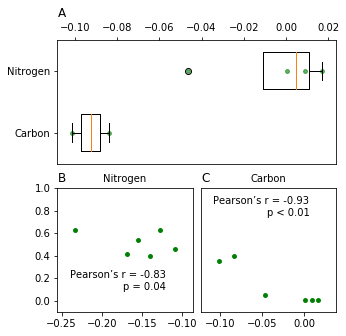

In [46]:
gs = gridspec.GridSpec(2, 39) 
fig1 = plt.figure(figsize=(5,5))
#Here I generate sub figure object and assign to corresponding location
ax1=fig1.add_subplot(gs[0:1, :39])   

ax1.set_title('A',loc='left',fontsize=12)
r_coef_df = pd.DataFrame({'pearson_coef_cd':np.transpose(total_pearson_coef_cd_transcriptome)[2].tolist()+np.transpose(total_pearson_coef_cd_transcriptome)[0].tolist(),
    'nutrient':['Nitrogen']*len(total_pearson_coef_cd_transcriptome)+['Carbon']*len(total_pearson_coef_cd_transcriptome),'sig_label':np.transpose(sig_label)[2,list_with_expression].tolist()+np.transpose(sig_label)[0,list_with_expression].tolist()})
group = ['nutrient','sig_label']
column = 'pearson_coef_cd'
grouped = r_coef_df.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.00, subdf.shape[0]))
new_vals=[vals[0],vals[1]]
new_names=['Carbon','Nitrogen']
ax1.boxplot(new_vals, labels=new_names,vert=0,widths = 0.6)
# ngroup = len(vals)
clevels = ['blue','red','blue']
point_size=15
ax1.scatter(vals[0], xs[0],  alpha=0.6,s=point_size,c='green')
ax1.scatter(vals[1],  xs[1], alpha=0.6,s=point_size,c='green')

ax1.xaxis.tick_top()




ax3=fig1.add_subplot(gs[1:,:19]) 
ax3.set_ylim(-0.1, 1)
ax3.set_title('B',loc='left',fontsize=12)
ax3.set_title('Nitrogen',loc='center',fontsize=10)
ax3.scatter(x=np.transpose(total_pearson_coef_cd_transcriptome)[2],y=np.transpose(total_pvalue_NC_3)[2,list_with_expression],s=15,c='green')


ax4=fig1.add_subplot(gs[1:,20:39],sharey=ax3) 
ax4.set_title('C',loc='left',fontsize=12)
ax4.set_title('Carbon',loc='center',fontsize=10)
ax4.scatter(x=np.transpose(total_pearson_coef_cd_transcriptome)[0],y=np.transpose(total_pvalue_NC_3)[0,list_with_expression],s=15,c='green')
ax4.axes.yaxis.set_visible(False)
ax3.text(0.8,0.3, "Pearson’s r = -0.83", size=10, ha="right",verticalalignment='center', transform=ax3.transAxes)
ax3.text(0.8,0.2, "p = 0.04", size=10, ha="right",verticalalignment='center', transform=ax3.transAxes)
ax4.text(0.8,0.9, "Pearson’s r = -0.93", size=10, ha="right",verticalalignment='center', transform=ax4.transAxes)
ax4.text(0.8,0.8, "p < 0.01", size=10, ha="right",verticalalignment='center', transform=ax4.transAxes)

# plt.savefig('../Figure/Fig_S1.pdf')

####  **1.2.2 Figure S2**

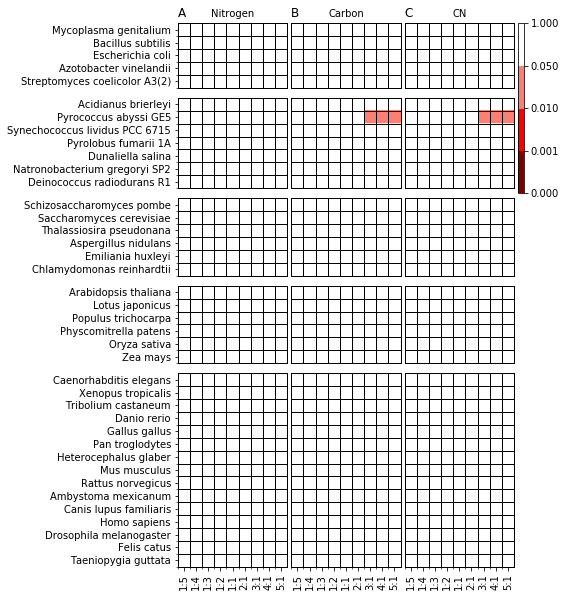

In [38]:
#  new_path=Path_ab2+'Figure'
pname=new_path+'/FigureS3.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


# y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
# the width ratio of subplot
# I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(8,10),sharey='row')

np.transpose(axes)[0,]

# The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

# this is for nitrogen
for a,b,c in zip(range(3),Nutrient_list,Nutrient_name_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,:6],Group_name_list):

        temp_data=extract_one_measurement(y,Total_pvalue_dic_MS_NC,b)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1

        # set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

        # set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        # here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        
        x.set_xticklabels(x_label,rotation='vertical')
        x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
        if count!=5:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Nitrogen',loc='center',fontsize=10)
axes[0,0].set_title('A',loc='left',fontsize=12)

axes[0,1].set_title('Carbon',loc='center',fontsize=10)
axes[0,1].set_title('B',loc='left',fontsize=12)

axes[0,2].set_title('CN',loc='center',fontsize=10)
axes[0,2].set_title('C',loc='left',fontsize=12)
# I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
#  plt.savefig(pname)

####  **1.2.3 Figure S3**

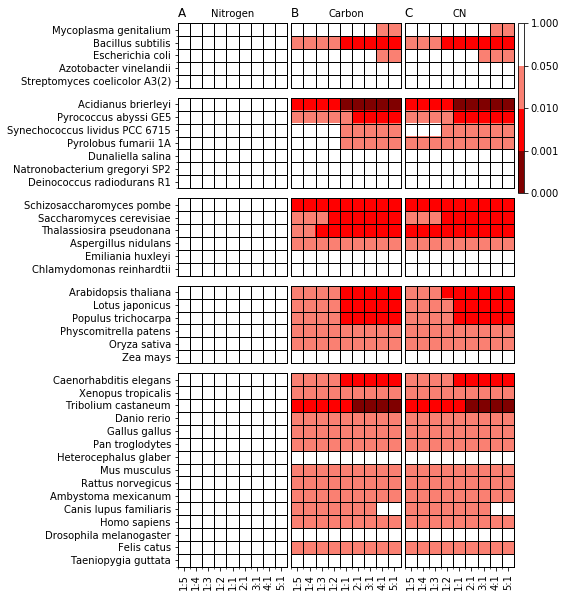

In [39]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Figure_S3.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(8,10),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen
for a,b,c in zip(range(3),Nutrient_list,Nutrient_name_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,:6],Group_name_list):

        temp_data=extract_one_measurement(y,Total_pvalue_dic_NC,b)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1

        #set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

        #set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        #here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        
        x.set_xticklabels(x_label,rotation='vertical')
        x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
        if count!=5:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Nitrogen',loc='center',fontsize=10)
axes[0,0].set_title('A',loc='left',fontsize=12)

axes[0,1].set_title('Carbon',loc='center',fontsize=10)
axes[0,1].set_title('B',loc='left',fontsize=12)

axes[0,2].set_title('CN',loc='center',fontsize=10)
axes[0,2].set_title('C',loc='left',fontsize=12)
#I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
# plt.savefig(pname)

####  **1.2.4 Figure S4**
This figure is not shown in the ms

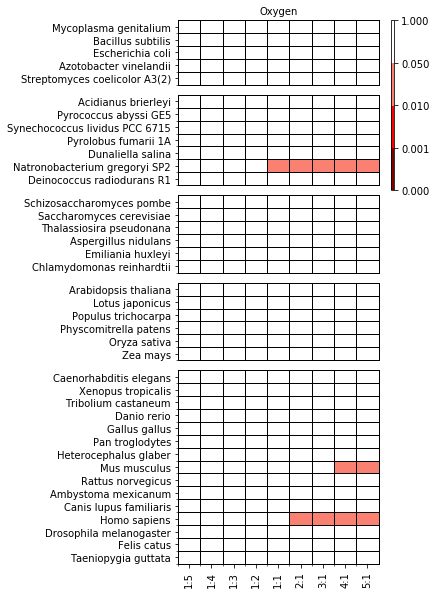

In [40]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Figure_S4.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 2, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,1] },figsize=(5,10),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen

count=0
for x,y in zip(np.transpose(axes)[0,:6],Group_name_list):

    temp_data=extract_one_measurement(y,Total_pvalue_dic_NC_NS,1)[:,1:]
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    count+=1

    #set x/y major tick
    x.set_xticks(np.arange(len(x_label)))
    x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

    #set x/y minor tick
    x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
    x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
    x.grid(which='minor', color='black', linestyle='-', linewidth=1)

    #here I specify the border line width
    for axis in ['top','bottom','left','right']:
        x.spines[axis].set_linewidth(1)

    x.set_xticklabels(x_label,rotation='vertical')
    x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
    if count!=5:
        plt.setp(x.get_xticklabels(), visible=False)
        x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Oxygen',loc='center',fontsize=10)

#I remove unwanted axis
for x in np.transpose(axes)[1,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
# plt.savefig(pname)